In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Load Data
# We only need TSLA for this task as per instructions
df = pd.read_csv('../data/processed/cleaned_adj_close.csv', index_col='Date', parse_dates=True)
tsla_data = df[['TSLA']]

print("Data Loaded. Shape:", tsla_data.shape)

Data Loaded. Shape: (2775, 1)


Training Data: 2523 days (End: 2025-01-13)
Testing Data: 252 days (Start: 2025-01-14)


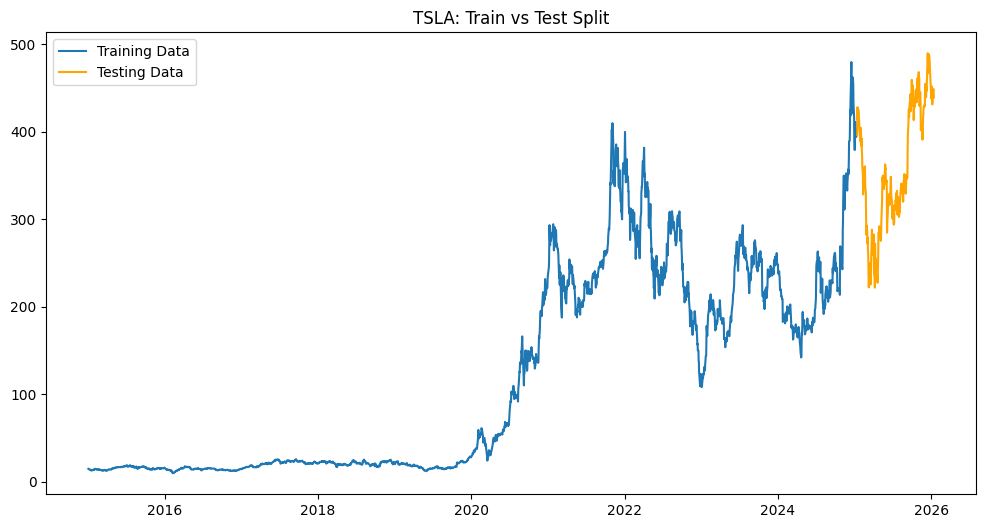

In [3]:
# 3. Train/Test Split (Chronological)
# We reserve the last year (approx 252 trading days) for testing
test_size = 252 
train_data = tsla_data[:-test_size]
test_data = tsla_data[-test_size:]

print(f"Training Data: {train_data.shape[0]} days (End: {train_data.index[-1].date()})")
print(f"Testing Data: {test_data.shape[0]} days (Start: {test_data.index[0].date()})")


# Visualizing the Split
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='orange')
plt.title('TSLA: Train vs Test Split')
plt.legend()
plt.show()

Starting Auto-ARIMA optimization...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16459.280, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16455.924, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16457.623, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16457.625, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16455.427, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.055 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2523
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8226.713
Date:                Sun, 25 Jan 2026   AIC                          16455.427
Time:                        09:19:12   BIC                          16461.259
Sample:                             0   HQIC                         16457.543
                               - 25

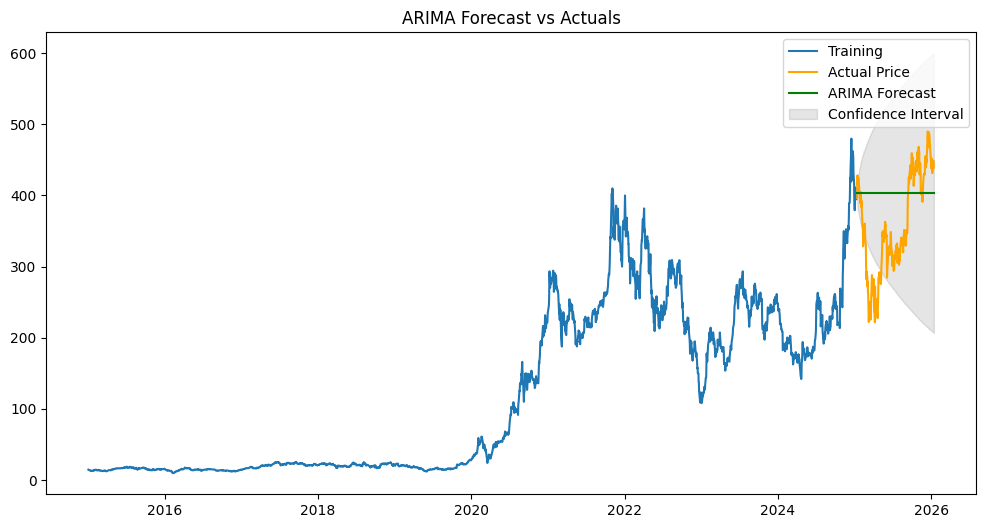

In [7]:
# 4. ARIMA Implementation (Auto-ARIMA)

print("Starting Auto-ARIMA optimization...")
# stepwise=True makes it faster. seasonal=False for daily stock data usually works best (too much noise for seasonality)
model_arima = auto_arima(train_data, 
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         m=1,             # Frequency (1 for non-seasonal)
                         seasonal=False,  # Daily stock data is generally non-seasonal
                         d=None,          # Let model determine 'd' (differencing)
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(model_arima.summary())

# 5. Forecasting with ARIMA
forecast_arima, conf_int = model_arima.predict(n_periods=len(test_data), return_conf_int=True)

# --- FIX: Use .values to avoid Index Alignment errors ---
# pmdarima returns a Series with a 'Daily' index (including weekends).
# We strip the index using .values to align strictly by position with our Test Data.
forecast_series = pd.Series(forecast_arima.values if isinstance(forecast_arima, pd.Series) else forecast_arima, index=test_data.index)

lower_series = pd.Series(conf_int[:, 0], index=test_data.index)
upper_series = pd.Series(conf_int[:, 1], index=test_data.index)

# Check for NaNs just to be safe
if forecast_series.isna().sum() > 0:
    print("Warning: NaNs detected in forecast. Filling with forward fill.")
    forecast_series = forecast_series.ffill()

# Plotting ARIMA Results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['TSLA'], label='Training')
plt.plot(test_data.index, test_data['TSLA'], label='Actual Price', color='orange')
plt.plot(test_data.index, forecast_series, label='ARIMA Forecast', color='green')
plt.fill_between(test_data.index, lower_series, upper_series, color='k', alpha=0.1, label='Confidence Interval')
plt.title('ARIMA Forecast vs Actuals')
plt.legend()
plt.show()

LSTM Train Shape: (2463, 60, 1)
LSTM Test Shape: (252, 60, 1)
Training LSTM...
Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0096
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0018
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0015
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0015
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0012
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0011
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0011
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0011
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0010
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0011
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 9.0696e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.4522e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step

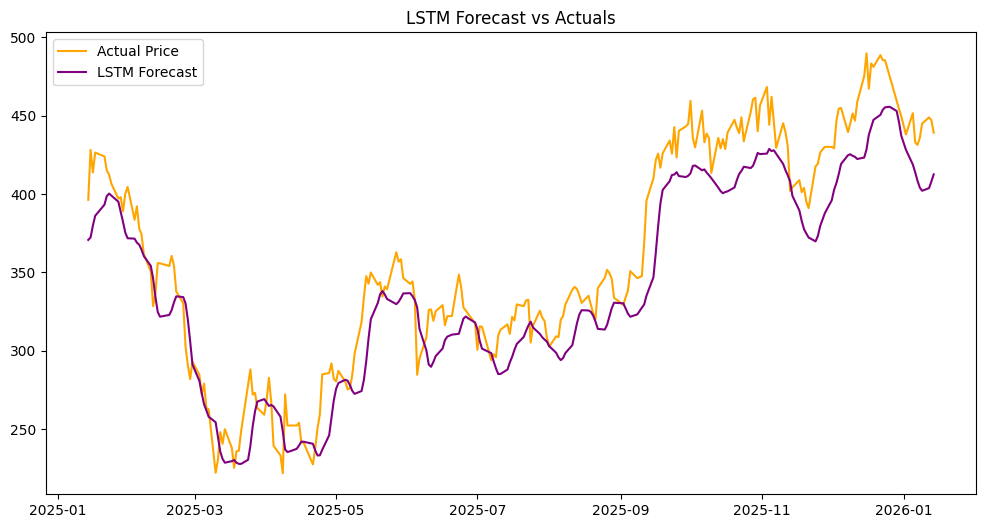

In [8]:
# 6. LSTM Data Preparation

# Scale the data (LSTMs are sensitive to scale)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_data)

# Function to create sequences (e.g., use past 60 days to predict day 61)
def create_sequences(data, seq_length=60):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

SEQ_LENGTH = 60

# Create sequences
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into Train/Test based on the original chronological split size
# We need to adjust indices because the first 60 days are consumed for the sequence
train_size = len(train_data) - SEQ_LENGTH
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"LSTM Train Shape: {X_train.shape}")
print(f"LSTM Test Shape: {X_test.shape}")

# 7. Build and Train LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print("Training LSTM...")
history = model_lstm.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# 8. LSTM Forecasting
predictions = model_lstm.predict(X_test)
# Inverse transform to get actual prices back
predictions = scaler.inverse_transform(predictions)

# Align predictions with dates
lstm_forecast_series = pd.Series(predictions.flatten(), index=test_data.index)

# Plot LSTM Results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['TSLA'], label='Actual Price', color='orange')
plt.plot(test_data.index, lstm_forecast_series, label='LSTM Forecast', color='purple')
plt.title('LSTM Forecast vs Actuals')
plt.legend()
plt.show()

In [9]:
# 9. Model Evaluation

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Calculate metrics for ARIMA
mae_arima, rmse_arima, mape_arima = calculate_metrics(test_data['TSLA'], forecast_series)

# Calculate metrics for LSTM
mae_lstm, rmse_lstm, mape_lstm = calculate_metrics(test_data['TSLA'], lstm_forecast_series)

# Create Comparison Table
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)'],
    'ARIMA': [mae_arima, rmse_arima, mape_arima],
    'LSTM': [mae_lstm, rmse_lstm, mape_lstm]
})

print("\n--- Model Comparison Results ---")
print(metrics_df)

# Discussion Logic
print("\n--- Discussion ---")
if mae_lstm < mae_arima:
    print("LSTM performed better. Deep learning models often capture complex non-linear patterns better than ARIMA.")
else:
    print("ARIMA performed better. Sometimes simpler statistical models outperform complex ones on financial data with high noise.")


--- Model Comparison Results ---
     Metric      ARIMA       LSTM
0       MAE  71.010436  21.647533
1      RMSE  83.773536  25.994705
2  MAPE (%)  23.048457   5.938056

--- Discussion ---
LSTM performed better. Deep learning models often capture complex non-linear patterns better than ARIMA.
